In [ ]:
import os
import sys
import shutil
import glob
import random


**Copy data from google drive**

In [ ]:
#Download the kaggle api token json file and upload it in colab 
# you can delete this cell or comment it  if you already have the dataset
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database


 99% 739M/745M [00:22<00:00, 31.6MB/s]
100% 745M/745M [00:22<00:00, 34.5MB/s]


In [ ]:
!unzip /content/covid19-radiography-database.zip

**Data Preparation**

In [ ]:
import pathlib

In [ ]:
dataset_path = '/content/COVID-19_Radiography_Dataset/'
data_dir = pathlib.Path(dataset_path)

In [ ]:
def count(c) :

  ''' return number of image in each catagory'''
  catagories = {key:0 for key in c }
  
  for catagory in c :
    catagories[catagory] = len(list(data_dir.glob(catagory+'/*.png')))
  return catagories

In [ ]:
img_class_dict = count(['COVID','Normal'])
print(f'{img_class_dict}')

{'COVID': 3616, 'Normal': 10192}


In [ ]:
import plotly.graph_objects as go

In [ ]:
def plotbarchart(d) :

  fig = go.Figure([go.Bar( x=list(d.keys()), y=list(d.values()))])
  fig.show()

plotbarchart(img_class_dict)

**We will use undersampling since we have dataset imbalance**

In [ ]:
#let us count the class with minimum number of samples

minority_class_count = min(img_class_dict.values())
minority_class_count

3616

In [ ]:
def create_folders() :

  '''create folder train_test_split and have three folders under it train ,test ,val and 
  each folder will contain covid,normal ,and pneumonia folder''' 

  parent = '/content/train_test_split/'
  os.mkdir(parent) 

  for folder in  ['train','test','val']:
    for catagory in img_class_dict.keys() :
      p = os.path.join('/content/train_test_split/',folder)
      q = os.path.join(p,catagory)
      os.makedirs(q)


In [ ]:
create_folders()

In [ ]:
train_dir = '/content/train_test_split/train/'
test_dir = '/content/train_test_split/test/'
val_dir = '/content/train_test_split/val/'

In [ ]:
def train_test_split(src,catagories,n) : 

  '''arrange dataset in train test split'''

  if not isinstance(src,pathlib.PosixPath) :
    print(f'{src} must be an instance of pathlib.PosixPath')
  
  #contain sample size of each catagories
  d = {}
  
  d['train_count'] = int(n * 0.7)
  d['test_count'] = int(n * 0.2)
  d['val_count'] = int(n * 0.1)

  dirs = [train_dir,test_dir,val_dir]

  for catagory in catagories :
    dst = os.path.join(train_dir,catagory+'/')
    for img in random.sample(list(data_dir.glob(catagory+'/*.png')),d['train_count']) :
      shutil.move(str(img),dst)
    
  
  for catagory in catagories :
    dst = os.path.join(test_dir,catagory+'/')
    for img in random.sample(list(data_dir.glob(catagory+'/*.png')),d['test_count']) :
      shutil.move(str(img),dst)

  for catagory in catagories :
    dst = os.path.join(val_dir,catagory+'/')
    for img in random.sample(list(data_dir.glob(catagory+'/*.png')),d['val_count']) :
      shutil.move(str(img),dst)

In [ ]:
img_categories = list(img_class_dict.keys())
train_test_split(data_dir,img_categories,minority_class_count)

In [ ]:
data_dir2 = pathlib.Path('/content/train_test_split/')

In [ ]:
def count_after(x,y) :
  c = {key: 0 for key in ['train','test','val']}

  for folder in c.keys():
    for catagory in y:
      c[folder] = len(list(x.glob(folder+'/'+catagory+'/*.png')))
  return c 

In [ ]:
new_count = count_after(data_dir2,img_categories)
print(f'{new_count}')

{'train': 2531, 'test': 723, 'val': 361}


**Data Visualization**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def grouped_bar_chart() :

  y1 = [new_count['train'],new_count['test'],new_count['val']] 
  y2 = [new_count['train'],new_count['test'],new_count['val']] 
  #y3 = [new_count['train'],new_count['test'],new_count['val']] 
  width = 0.4
  
  x = np.arange(3)
  # plot data in grouped manner of bar type
  #plt.bar(x-0.4, y1, width, color='cyan')
  plt.bar(x-0.2, y1, width, color='blue')
  plt.bar(x+0.2, y2, width, color='green')
  plt.xticks(x, list(new_count.keys()))
  plt.xlabel("Datasets")
  plt.ylabel("Quantity")
  plt.legend(img_categories)
  plt.show()

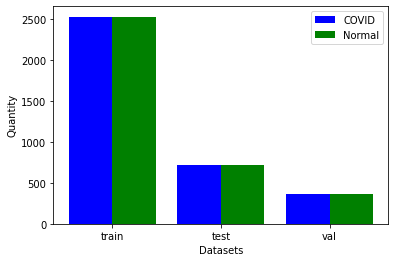

In [ ]:
grouped_bar_chart()

In [ ]:
def plotImageGray(batch)  :
  
  #plt.style.use('seaborn')
  imgs,labels = batch
  # create figure
  fig = plt.figure(figsize=(10, 7))

  rows = 2
  columns = 3
  s = 1

  for img,label in zip(imgs[:6],labels[:6]):

    fig.add_subplot(rows, columns, s)

    # showing image
    plt.imshow(np.squeeze(img),cmap='gray',interpolation='nearest')
    plt.title(img_categories[np.argmax(label)])
    plt.axis('off')

    s+=1 

  plt.show()

In [ ]:
def plotImage(batch)  :
  
  plt.style.use('seaborn')
  imgs,labels = batch
  # create figure
  fig = plt.figure(figsize=(10, 7))

  rows = 2
  columns = 3
  s = 1

  for img,label in zip(imgs[:6],labels[:6]):

    fig.add_subplot(rows, columns, s)
    image = (img*255).astype(np.uint8)

    # showing image
    plt.imshow(image)
    plt.title(img_categories[np.argmax(label)])
    plt.axis('off')

    s+=1 

  plt.show()

In [ ]:
def show_final_history(history):

    plt.style.use('seaborn')
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

**Dataset Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
def apply_augmentation(path,name=None,mode='grayscale') :

  '''apply various augmentation to training samples only '''

  if name != None : 

       if name == 'train' :
         datagen = ImageDataGenerator(zoom_range= 0.2, horizontal_flip= True, shear_range= 0.2 ,rescale=1./255) 
         batches = datagen.flow_from_directory(directory=path,target_size=(224,224),color_mode=mode)

       elif name == 'val' :
         datagen = ImageDataGenerator(rescale=1./255)
         batches = datagen.flow_from_directory(directory=path,target_size=(224,224),color_mode=mode)

       elif name == 'test' :
          datagen = ImageDataGenerator(rescale=1./255)
          batches = datagen.flow_from_directory(directory=path,target_size=(224,224),shuffle=False,color_mode=mode)
       else :
         print('Enter valid name')
  else :
    print('Please provide name ')
    return 

  return batches 

In [ ]:
train_batch = apply_augmentation(train_dir,'train')

Found 5062 images belonging to 2 classes.


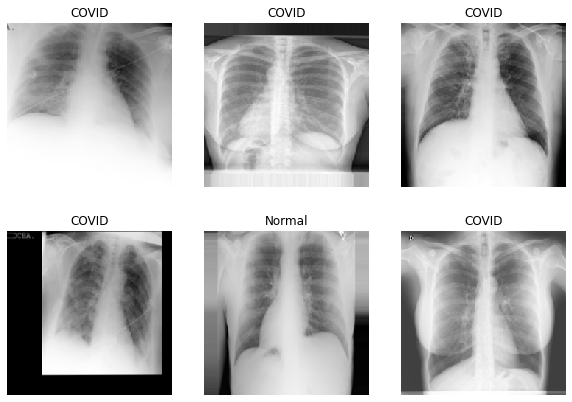

In [ ]:
#visualizing train batches
plotImageGray(next(train_batch))

In [ ]:
val_batch = apply_augmentation(val_dir,'val')

Found 722 images belonging to 2 classes.


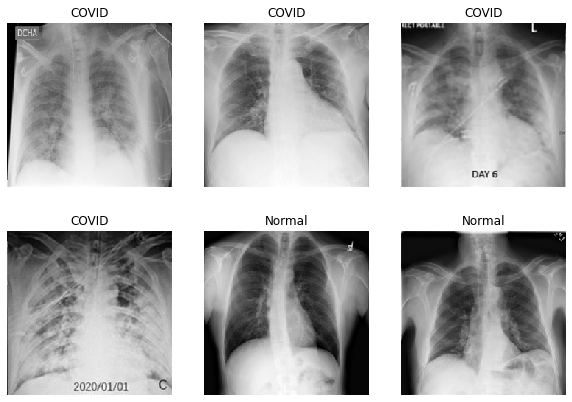

In [ ]:
#visualizing validation batches
plotImageGray(next(val_batch))

In [ ]:
test_batch = apply_augmentation(test_dir,'test')

Found 1446 images belonging to 2 classes.


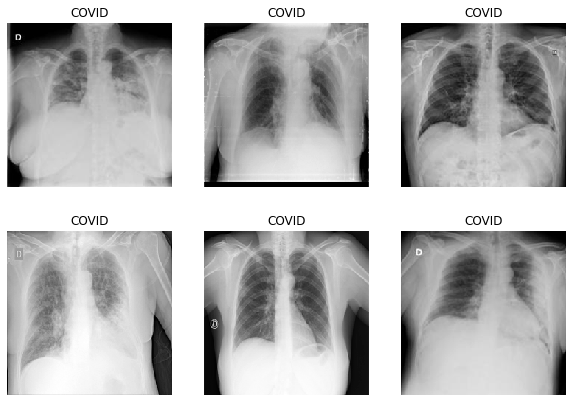

In [ ]:
#visualize test batch
plotImageGray(next(test_batch))

**Building Model**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


In [ ]:
def cnn() :

  #define the input
  input = Input(shape=(224,224,1))

  conv1 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv1')(input)
  pool1 = MaxPool2D()(conv1)

  conv2 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv2')(pool1)
  pool2 = MaxPool2D()(pool1)

  conv3 = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',name='conv3')(pool2)
  pool3 = MaxPool2D()(conv3)

  conv4 = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',name='conv4')(pool3)
  pool4 = MaxPool2D()(conv4)
  
 
  conv5 = Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',name='conv5')(pool4)
  pool5 = MaxPool2D()(conv5)

  conv6 = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',name='conv6')(pool5)
  pool6 = MaxPool2D()(conv6)
  

  conv7 = Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same',name='conv7')(pool6)
  pool7 = MaxPool2D()(conv7)


  flat = Flatten()(pool7)

  outputs = Dense(units=2,activation='softmax',name='prediction')(flat)

  #building the model

  model = Model(input,outputs)

  return model

In [ ]:
def transfer() :

  '''use a pretrained VGG16 model to classify chest x ray'''

  vgg = VGG16(include_top=False,weights="imagenet",input_shape=(224,224,3))

  #we do not want to train all the layer so we are making them untrainable
  for layer in vgg.layers :
   layer.trainable = False
  
  #now let us add our own layers on top for our probleme

  flat = Flatten()(vgg.output)
  output = Dense(units = 2,activation='softmax',name='prediction')(flat)

  model = Model(vgg.input,output)
  return model 


**Model Training**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [ ]:
fp = '/content/MODEL1/model1.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

In [ ]:
#stop the training if the validation loss stop decressing 5 consecutive times
es = EarlyStopping(monitor='val_loss',patience=5,mode='min')

#save the model with higest validation accuracy
mc = ModelCheckpoint(filepath=fp, monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')

In [ ]:
def train(model,tb=train_batch,vb=val_batch,EPOCH=10,cb=[es,mc]) :

  '''training the model''' 
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  history = model.fit(tb,validation_data=vb,epochs=EPOCH,callbacks=cb)

  show_final_history(history)

**Training the model built from scratch**

In [ ]:
model1 = cnn()
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 224, 224, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0     

Epoch 1/10
159/159 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5239
Epoch 00001: val_accuracy improved from -inf to 0.50139, saving model to /content/MODEL1/model1.epoch01-loss0.69.hdf5
159/159 [==============================] - 48s 236ms/step - loss: 0.6906 - accuracy: 0.5239 - val_loss: 0.6920 - val_accuracy: 0.5014
Epoch 2/10
159/159 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.6482
Epoch 00002: val_accuracy improved from 0.50139 to 0.70637, saving model to /content/MODEL1/model1.epoch02-loss0.57.hdf5
159/159 [==============================] - 37s 231ms/step - loss: 0.6265 - accuracy: 0.6482 - val_loss: 0.5690 - val_accuracy: 0.7064
Epoch 3/10
159/159 [==============================] - ETA: 0s - loss: 0.5835 - accuracy: 0.6964
Epoch 00003: val_accuracy improved from 0.70637 to 0.78255, saving model to /content/MODEL1/model1.epoch03-loss0.51.hdf5
159/159 [==============================] - 36s 227ms/step - loss: 0.5835 - accuracy:

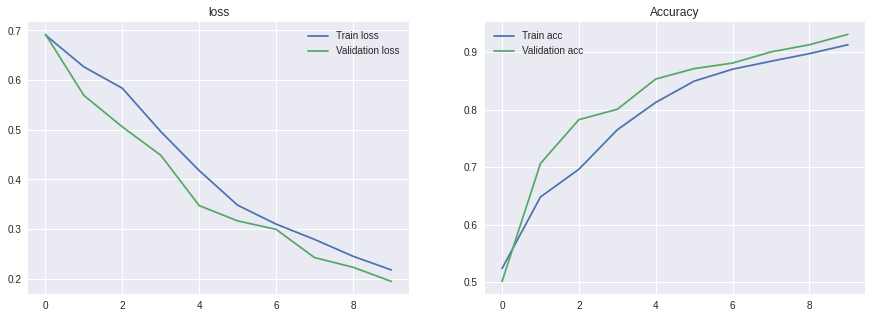

In [ ]:
train(model1)

**Training the pretrained vgg16 model**

In [ ]:
#since the vgg16 model accept rgb images we have to read them in rgb color model
#pass the argument model='rgb' to function apply_augmenation()


In [ ]:
train_batch_rgb = apply_augmentation(train_dir,name='train',mode='rgb')
val_batch_rgb = apply_augmentation(val_dir,name='val',mode='rgb')
test_batch_rgb = apply_augmentation(test_dir,name='test',mode='rgb')

Found 5062 images belonging to 2 classes.
Found 722 images belonging to 2 classes.
Found 1446 images belonging to 2 classes.


In [ ]:
model2 = transfer()
model2.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
#path to save best model2
fp2 = '/content/MODEL2/model1.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

#save the model with higest validation accuracy
mc2 = ModelCheckpoint(filepath=fp2, monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')

Epoch 1/10
159/159 [==============================] - ETA: 0s - loss: 0.4013 - accuracy: 0.8256
Epoch 00001: val_accuracy improved from -inf to 0.88643, saving model to /content/MODEL2/model1.epoch01-loss0.29.hdf5
159/159 [==============================] - 101s 566ms/step - loss: 0.4013 - accuracy: 0.8256 - val_loss: 0.2931 - val_accuracy: 0.8864
Epoch 2/10
159/159 [==============================] - ETA: 0s - loss: 0.2668 - accuracy: 0.8896
Epoch 00002: val_accuracy improved from 0.88643 to 0.89751, saving model to /content/MODEL2/model1.epoch02-loss0.25.hdf5
159/159 [==============================] - 83s 521ms/step - loss: 0.2668 - accuracy: 0.8896 - val_loss: 0.2505 - val_accuracy: 0.8975
Epoch 3/10
159/159 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9070
Epoch 00003: val_accuracy improved from 0.89751 to 0.91551, saving model to /content/MODEL2/model1.epoch03-loss0.20.hdf5
159/159 [==============================] - 82s 516ms/step - loss: 0.2340 - accuracy

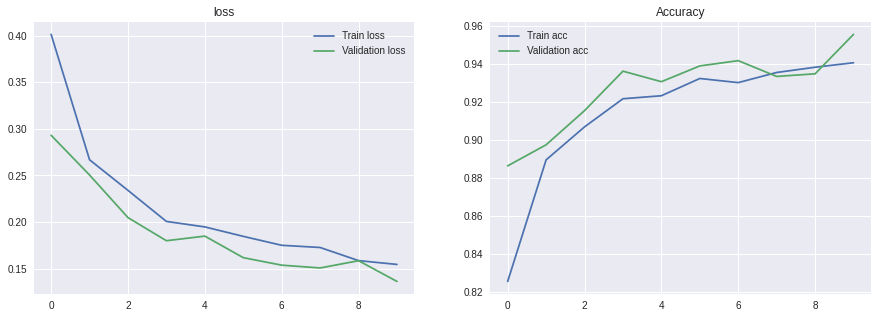

In [ ]:
train(model2,tb=train_batch_rgb,vb=val_batch_rgb,cb=[es,mc2],EPOCH=10)

**Model Performance Evaluation**

1. Accuracy
2. Precission
3. Recall
4. F1 Score

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix , classification_report 

In [ ]:
#let us create a confusion matrix to see how our model has acctually performed 
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

1 . **Evaluating The Model That is  Built From Scratch(model1)**

In [ ]:
#load the best model1
best_model1 = load_model('/content/MODEL1/model1.epoch10-loss0.19.hdf5')

In [ ]:
#Accuracy 
print(best_model1.evaluate(test_batch))

46/46 [==============================] - 4s 85ms/step - loss: 0.1465 - accuracy: 0.9391
[0.1464819759130478, 0.9391424655914307]


In [ ]:
test_batch.reset()
pred = best_model1.predict(test_batch)

Confusion matrix, without normalization
[[669  54]
 [ 34 689]]


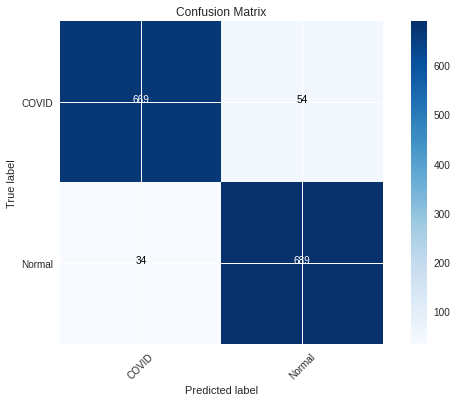

In [ ]:
cm_plot_labels = img_categories
cm = confusion_matrix(y_true=test_batch.classes,y_pred = np.argmax(pred,axis = -1))
plot_confusion_matrix(cm = cm,classes=cm_plot_labels,title='Confusion Matrix')

In [ ]:
print(classification_report(test_batch.classes,np.argmax(pred,axis=-1),target_names=img_categories))

              precision    recall  f1-score   support

       COVID       0.95      0.93      0.94       723
      Normal       0.93      0.95      0.94       723

    accuracy                           0.94      1446
   macro avg       0.94      0.94      0.94      1446
weighted avg       0.94      0.94      0.94      1446



2.**Evaluating Pretrained VGG16 model(transfer learning)**

In [ ]:
best_model2 = load_model('/content/MODEL2/model1.epoch10-loss0.14.hdf5')

In [ ]:
#Accuracy
print(best_model2.evaluate(test_batch_rgb))

46/46 [==============================] - 12s 243ms/step - loss: 0.1281 - accuracy: 0.9544
[0.12806300818920135, 0.954356849193573]


In [ ]:
test_batch_rgb.reset()
pred2 = best_model2.predict(test_batch_rgb)

Confusion matrix, without normalization
[[685  38]
 [ 28 695]]


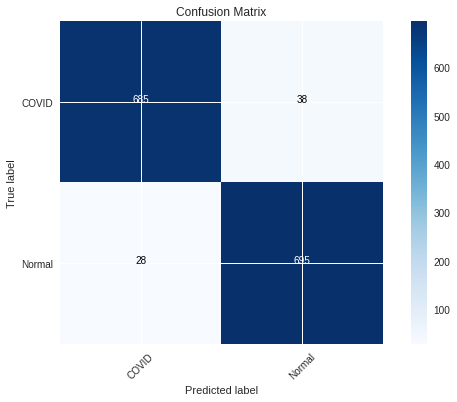

In [ ]:
cm_plot_labels = img_categories
cm = confusion_matrix(y_true=test_batch_rgb.classes,y_pred = np.argmax(pred2,axis = -1))
plot_confusion_matrix(cm = cm,classes=cm_plot_labels,title='Confusion Matrix')

In [ ]:
print(classification_report(test_batch_rgb.classes,np.argmax(pred2,axis=-1),target_names=img_categories))

              precision    recall  f1-score   support

       COVID       0.96      0.95      0.95       723
      Normal       0.95      0.96      0.95       723

    accuracy                           0.95      1446
   macro avg       0.95      0.95      0.95      1446
weighted avg       0.95      0.95      0.95      1446



**Make some predictions on actual chest x-ray images**

In [ ]:
from tensorflow.keras.utils import load_img,img_to_array
from PIL import Image

In [ ]:
def plot_predictions(img,y_pred) :

  '''plot an image with its actual label along with predicted label'''

  plt.imshow(img)
  plt.axis('off')
  plt.title(f'Predicted {y_pred}')
  plt.show()
  

In [ ]:
def make_prediction(p,model)  :

  '''load an image convert it to an numpy array of rank 4 and plot and make prediction'''

  if model.input.shape[-1] == 3 :
    img = load_img(path=p,target_size=(224,224))
  else :
    img = load_img(path=p,color_mode='grayscale',target_size=(224,224))

  img_arr = np.asarray(img)
  img_arr = np.expand_dims(img_arr,axis=0)
  pred = model.predict(img_arr)

  plot_predictions(img,img_categories[np.argmax(pred)])
  print(pred[0])

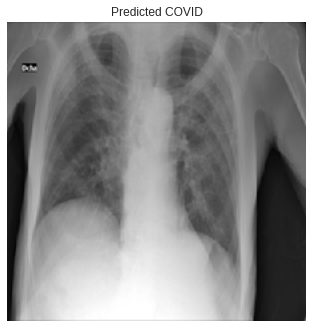

[1. 0.]


In [ ]:
p = '/content/COVID-19_Radiography_Dataset/COVID/COVID-1331.png'
make_prediction(p,best_model2)

3